# 构建RPN(Region Proposal Network)网络
基于滑动窗口的无类别Object检测器，输入特征图像，输出多个矩形候选区域

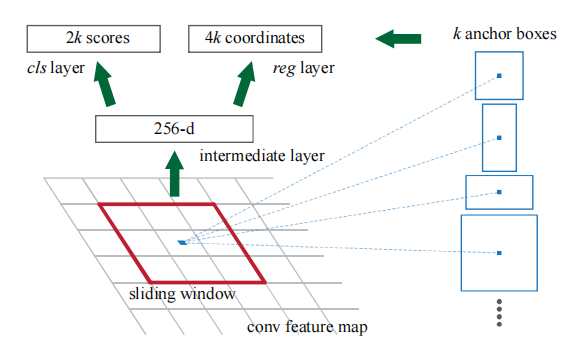

## 首先定义RPN网络的各个参数
在config.py文件中保存

In [1]:
    ANCHOR_RATIOS = [0.5, 1, 2]      #RPN 使用的锚框的长宽比列表。 那么根据宽高比 0.5，1 和 2，
                                    #将会生成三个锚点框，分别是 0.5W x H，W x H 和 2W x H。
    RPN_NMS_IOU_THRESHOLD = 0.7      #RPN 在执行非极大值抑制（NMS）时的 IoU 阈值。
    RPN_IOU_POSITIVE_THRESHOLD = 0.7    # 用于判定正样本的 IoU 阈值。
    RPN_IOU_NEGATIVE_THRESHOLD = 0.3    # 用于判定负样本的 IoU 阈值。
    RPN_MINIBATCH_SIZE = 256            #用于计算 RPN 损失的小批量样本数。
    RPN_POSITIVE_RATE = 0.5             #正样本比例
    RPN_TOP_K_NMS = 6000                #在 NMS 之后，保留的前 k 个锚框。
    MAX_PROPOSAL_NUM_TRAINING = 2000    #训练时，RPN 生成的最大区域建议数量
    MAX_PROPOSAL_NUM_INFERENCE = 1000   #推断时，RPN 生成的最大区域建议数量
    RPN_BBOX_STD_DEV = [0.1, 0.1, 0.25, 0.27]   #用于计算 RPN 边界框编码的标准偏差。
    BBOX_STD_DEV = [0.13, 0.13, 0.27, 0.26]     #用于计算边界框编码的标准偏差

## 构建RPN类 来搭建网络结构 定义生成区域建议的方法

先导入所需要的包

In [ ]:
# # -*- coding: utf-8 -*-

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.contrib.slim as slim

from libs.box_utils import make_anchor
from libs.box_utils import boxes_utils
from libs.box_utils import encode_and_decode

from libs import losses

### 创建RPN类 初始化各个参数 接收来自FPN提取的各个特征图

In [ ]:
class RPN(object):
    def __init__(self,
                 feature_pyramid,
                 image_window,
                 config):

        self.feature_pyramid = feature_pyramid
        self.window = image_window
        self.config = config
        self.anchor_ratios = tf.constant(config.ANCHOR_RATIOS, dtype=tf.float32)
        self.num_of_anchors_per_location = len(config.ANCHOR_RATIOS)
        self.rpn_encode_boxes, self.rpn_scores = self.rpn_net()

### 创建RPN网络 对每个特征图进行区域建议，生成预测框和对应分数并输出。所有的锚框都是按照P2到P6的顺序生成

In [ ]:
    def rpn_net(self):
        """
        base the anchor stride to compute the output(batch_size, object_scores, pred_bbox) of every feature map,
        now it supported the multi image in a gpu
        return
        rpn_all_encode_boxes(batch_size, all_anchors, 4)
        rpn_all_boxes_scores(batch_size, all_anchors, 2)
        Be Cautious:
        all_anchors is concat by the order of ［P2, P3, P4, P5, P6］ which request that
        the anchors must be generated by this order.
        """
        
        #创建每一层特征图的预测框和分数 列表
        rpn_encode_boxes_list = []
        rpn_scores_list = []

        with tf.variable_scope('rpn_net'):    #创建名为'rpn_net'的作用域
            with slim.arg_scope([slim.conv2d],   #为slim.conv2d定义默认参数 包括权重初始化和正则化（用于防止过拟合）
                                weights_initializer=tf.glorot_uniform_initializer(),
                                weights_regularizer=slim.l2_regularizer(self.config.WEIGHT_DECAY)):
                #对每一层的特征图进行预测
                for level in self.config.LEVEL:
                    reuse_flag = tf.AUTO_REUSE
                    scope_list = ['conv2d_3x3', 'rpn_classifier', 'rpn_regressor'] #定义三个变量
                    
                    #第一个3x3的卷积层作为滑动窗口，将该层的特征图输入，输出通道为512 用
                    rpn_conv2d_3x3 = slim.conv2d(inputs=self.feature_pyramid[level],
                                                 num_outputs=512,
                                                 kernel_size=[3, 3],
                                                 stride=self.config.RPN_ANCHOR_STRIDE,
                                                 scope=scope_list[0],
                                                 reuse=reuse_flag)
                    #第二个1x1的卷积，用来预测每个边框的分类分数 有两类为前景和背景类
                    rpn_box_scores = slim.conv2d(rpn_conv2d_3x3,
                                                 num_outputs=2 * self.num_of_anchors_per_location,  #每个位置有3个候选框,每个位置2类，输出为12
                                                 kernel_size=[1, 1],
                                                 stride=1,
                                                 scope=scope_list[1],
                                                 activation_fn=None,
                                                 reuse=reuse_flag)
                    #第三个1x1的卷积层,用于边界框进行回归
                    rpn_encode_boxes = slim.conv2d(rpn_conv2d_3x3,
                                                   num_outputs=4 * self.num_of_anchors_per_location,  #每个框都有四个坐标
                                                   kernel_size=[1, 1],
                                                   stride=1,
                                                   scope=scope_list[2],
                                                   activation_fn=None,
                                                   reuse=reuse_flag)
                    #对张量进行reshape，第一维是GPU处理的图像数，第二维表示每张图像的预测框可能不同用-1，第三维为类别个数
                    rpn_box_scores = tf.reshape(rpn_box_scores, [self.config.PER_GPU_IMAGE, -1, 2])
                    rpn_encode_boxes = tf.reshape(rpn_encode_boxes, [self.config.PER_GPU_IMAGE, -1, 4])
                    
                    rpn_scores_list.append(rpn_box_scores)
                    rpn_encode_boxes_list.append(rpn_encode_boxes)
                
                #将不同特征图上预测框和分数进行拼接
                rpn_all_encode_boxes = tf.concat(rpn_encode_boxes_list, axis=1)
                rpn_all_boxes_scores = tf.concat(rpn_scores_list, axis=1)

            return rpn_all_encode_boxes, rpn_all_boxes_scores

### 计算候选框的损失
包括分类损失和位置损失

In [ ]:
    def rpn_losses(self, minibatch_indices, minibatch_encode_gtboxes, minibatch_labels_one_hot):
        """
        :param minibatch_indices: (batch_size, config.RPN_MINIBATCH_SIZE)  预测框的索引
        :param minibatch_encode_gtboxes: (batch_size, config.RPN_MINIBATCH_SIZE, 4)  预测框对应真实边框的信息
        :param minibatch_labels_one_hot: (batch_size, config.RPN_MINIBATCH_SIZE, 2)  标签的独热编码表示
        :return: the mean of location_loss, classification_loss
        """
        #在作用域"rpn_loss"下
        with tf.variable_scope("rpn_losses"):
            
            #根据索引提取预测框和分数
            def batch_slice_rpn_target(mini_indices, rpn_encode_boxes, rpn_scores):
                """
                :param mini_indices: (config.RPN_MINIBATCH_SIZE, ) this is indices of anchors
                :param rpn_encode_boxes: (config.RPN_MINIBATCH_SIZE, 4)
                :param rpn_scores: (config.RPN_MINIBATCH_SIZE, 2)
                """
                mini_encode_boxes = tf.gather(rpn_encode_boxes, mini_indices)
                mini_boxes_scores = tf.gather(rpn_scores, mini_indices)

                return mini_encode_boxes, mini_boxes_scores
            
            #将数据切分为多个片段 再分批次传入函数
            mini_encode_boxes, mini_boxes_scores = boxes_utils.batch_slice([minibatch_indices,
                                                                            self.rpn_encode_boxes,
                                                                            self.rpn_scores],
                                                                            lambda x, y, z: batch_slice_rpn_target(x, y, z),
                                                                            self.config.PER_GPU_IMAGE)
            
            #得到物体的独热掩码 是否是物体
            object_mask = tf.cast(minibatch_labels_one_hot[:, :, 1], tf.float32)
            # losses
            #L1损失计算位置损失
            with tf.variable_scope('rpn_location_loss'):
                location_loss = losses.l1_smooth_losses(predict_boxes=mini_encode_boxes,
                                                        gtboxes=minibatch_encode_gtboxes,
                                                        object_weights=object_mask)
            #CE损失计算分类损失
            with tf.variable_scope('rpn_classification_loss'):

                classification_loss = tf.losses.softmax_cross_entropy(logits=mini_boxes_scores,
                                                                      onehot_labels=minibatch_labels_one_hot)
                classification_loss = tf.cond(tf.is_nan(classification_loss), lambda: 0.0, lambda: classification_loss)

            return location_loss, classification_loss

### 下面这个方法是生成一系列的候选框和分数

In [ ]:
    def rpn_proposals(self, is_training):
        """
        :param is_training:
        :return:
        rpn_proposals_boxes: (batch_size, config.MAX_PROPOSAL_SIZE, 4)(y1, x1, y2, x2)
        """
        #根据配置参数生成一组锚框
        anchors = make_anchor.generate_pyramid_anchors(self.config)
        if is_training:
            rpn_proposals_num = self.config.MAX_PROPOSAL_NUM_TRAINING
        else:
            rpn_proposals_num = self.config.MAX_PROPOSAL_NUM_INFERENCE

        #对每个候选框进行处理和筛选
        def batch_slice_rpn_proposals(rpn_encode_boxes, rpn_scores, anchors, config, rpn_proposals_num):
            
            #定义一个'rpn_proposals'作用域
            with tf.variable_scope('rpn_proposals'):
                #对rpn_scores进行softmox 概率表示 并取出概率分布中的第二列（索引为1），表示每个候选框属于物体的概率。
                rpn_softmax_scores = slim.softmax(rpn_scores)
                rpn_object_score = rpn_softmax_scores[:, 1]  # second column represent object
                
                #取出分数最前的K个候选框 并将分数、预测框、锚框分别保存在新列表中
                if config.RPN_TOP_K_NMS:
                    top_k_indices = tf.nn.top_k(rpn_object_score, k=config.RPN_TOP_K_NMS).indices
                    rpn_object_score = tf.gather(rpn_object_score, top_k_indices)
                    rpn_encode_boxes = tf.gather(rpn_encode_boxes, top_k_indices)
                    anchors = tf.gather(anchors, top_k_indices)
                
                #将编码框和锚框输入，解码成新的边界框坐标
                rpn_decode_boxes = encode_and_decode.decode_boxes(encode_boxes=rpn_encode_boxes,
                                                                  reference_boxes=anchors,
                                                                  dev_factors=config.RPN_BBOX_STD_DEV)
                #用非极大值抑制选取最佳的候选框 IoU阈值为0.7 高于0.7的框保留
                valid_indices = boxes_utils.non_maximal_suppression(boxes=rpn_decode_boxes,
                                                                    scores=rpn_object_score,
                                                                    max_output_size=rpn_proposals_num,
                                                                    iou_threshold=config.RPN_NMS_IOU_THRESHOLD)
                
                #将挑选后的边界框的下标 组成新的候选框和分数
                rpn_decode_boxes = tf.gather(rpn_decode_boxes, valid_indices)
                rpn_object_score = tf.gather(rpn_object_score, valid_indices)
                
                #将超出图片边界的候选框修剪掉 保证候选框处于图像内
                # clip proposals to img boundaries(replace the out boundary with image boundary)
                rpn_decode_boxes = boxes_utils.clip_boxes_to_img_boundaries(rpn_decode_boxes, [0, 0,
                                                                                               config.TARGET_SIDE-1,
                                                                                            config.TARGET_SIDE-1])
                #对候选框如果没有达到rpn_proposals_num 则进行填充，这个过程确保了每个图像的输出都有固定数量的候选框，
                #无论在每个图像中实际检测到了多少个候选框。这对于后续的处理和分析是非常有帮助的。
                # Pad if needed
                padding = tf.maximum(rpn_proposals_num - tf.shape(rpn_decode_boxes)[0], 0)
                # care about why we don't use tf.pad in there
                zeros_padding = tf.zeros((padding, 4), dtype=tf.float32)
                rpn_proposals_boxes = tf.concat([rpn_decode_boxes, zeros_padding], axis=0)
                rpn_object_score = tf.pad(rpn_object_score, [(0, padding)])

                return rpn_proposals_boxes, rpn_object_score
        
        #在每张图像上调用batch_slice_rpn_proposals
        rpn_proposals_boxes, rpn_object_scores = \
            boxes_utils.batch_slice([self.rpn_encode_boxes, self.rpn_scores],
                                    lambda x, y: batch_slice_rpn_proposals(x, y, anchors,
                                                                              self.config, rpn_proposals_num),
                                    self.config.PER_GPU_IMAGE)

        return rpn_proposals_boxes, rpn_object_scores